In [51]:
from sklearn.model_selection import train_test_split
import pandas as pd, os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

In [ ]:


DATA = r"C:\Users\habib\OneDrive\المستندات\Graduation Project\GRAD-proj-DEPI\DS1\Data\Clean\phase2_final_model_ready.csv"
assert os.path.exists(DATA), "Clean dataset not found."
df = pd.read_csv(DATA)

TARGET = "Heart Disease Class (0–4)"
NUM_all = ["Age (years)","Resting BP (mm Hg)","Cholesterol (mg/dl)",
           "Max Heart Rate (bpm)","ST Depression (oldpeak)"]
CAT_all = ["Chest Pain Type","Resting ECG","ST Slope","Thalassemia","Major Vessels (0–3)"]
BIN_all = ["Fasting Blood Sugar","Exercise Angina",
           "Fasting Blood Sugar Missing","Exercise Angina Missing"]

# Auto-create missing flags if absent
for base in ["Fasting Blood Sugar","Exercise Angina"]:
    flag = f"{base} Missing"
    if base in df.columns and flag not in df.columns:
        df[flag] = df[base].isna().astype(int)

cols = set(df.columns)
NUM = [c for c in NUM_all if c in cols]
CAT = [c for c in CAT_all if c in cols]
BIN = [c for c in BIN_all if c in cols]

X = df[NUM + CAT + BIN].copy()
y = df[TARGET].astype(int).copy()

print("Using -> NUM:", NUM)
print("Using -> CAT:", CAT)
print("Using -> BIN:", BIN)
print("Shapes:", X.shape, y.shape)


Using -> NUM: ['Age (years)', 'Resting BP (mm Hg)', 'Cholesterol (mg/dl)', 'Max Heart Rate (bpm)', 'ST Depression (oldpeak)']
Using -> CAT: ['Chest Pain Type', 'Resting ECG', 'ST Slope', 'Thalassemia', 'Major Vessels (0–3)']
Using -> BIN: ['Fasting Blood Sugar', 'Exercise Angina', 'Fasting Blood Sugar Missing', 'Exercise Angina Missing']
Shapes: (918, 14) (918,)


In [ ]:


num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

bin_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent"))
])

pre = ColumnTransformer([
    ("num", num_pipe, NUM),
    ("cat", cat_pipe, CAT),
    ("bin", bin_pipe, BIN)
], remainder="drop")


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (734, 14) Test: (184, 14)


In [7]:

def evaluate_model(pipe, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    try:
        y_proba = pipe.predict_proba(X_test)
        roc_macro = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    except Exception:
        roc_macro = np.nan

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    print("ROC-AUC (macro):", "NA" if np.isnan(roc_macro) else f"{roc_macro:.3f}")
    return roc_macro


`Interpretation:`

Precision: of all patients predicted to have class X, how many actually had it.

Recall: of all patients who truly had class X, how many did the model find.

F1-score: a balance between precision and recall.

Support: how many samples of that class exist in the test set.

Accuracy: overall correct predictions / total samples.

Macro average: average of all classes equally.

Weighted average: average weighted by class sizes.


=== Logistic Regression (balanced) ===
              precision    recall  f1-score   support

           0      0.853     0.780     0.815        82
           1      0.523     0.434     0.474        53
           2      0.217     0.227     0.222        22
           3      0.238     0.238     0.238        21
           4      0.190     0.667     0.296         6

    accuracy                          0.549       184
   macro avg      0.404     0.469     0.409       184
weighted avg      0.590     0.549     0.563       184



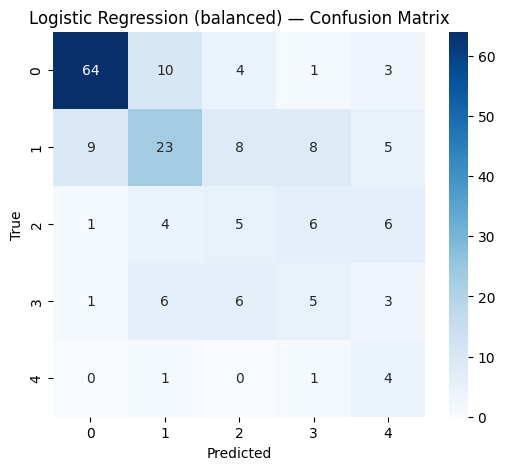

ROC-AUC (macro): 0.794


In [ ]:

# Logistic Regression (balanced)
lr_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))
])
auc_lr = evaluate_model(lr_pipe, "Logistic Regression (balanced)")

##in imbalanced data, macro average doesn’t let the majority class dominate the score;
# if the model is weak on minority classes, the macro score drops,
# so it exposes weaknesses that plain accuracy or micro averages can hide

The baseline Logistic Regression model achieved an overall accuracy of 54.9% and a macro-averaged F1-score of 40.9%.

The model performs well in identifying healthy patients (class 0) but shows limited ability to discriminate among disease severity levels (classes 1–4).

This indicates that the dataset may suffer from class imbalance and non-linear relationships that Logistic Regression cannot capture effectively.

| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                                |
| ----- | -------------------- | --------- | ------ | ---- | ------- | -------------------------------------------------------------------- |
| **0** | No heart disease     | 0.85      | 0.78   | 0.82 | 82      | Very strong performance — model identifies healthy cases quite well. |
| **1** | Mild disease         | 0.52      | 0.43   | 0.47 | 53      | Struggles — detects some, misses others.                             |
| **2** | Moderate disease     | 0.22      | 0.23   | 0.22 | 22      | Weak — model can’t distinguish these patterns yet.                   |
| **3** | Severe disease       | 0.24      | 0.24   | 0.24 | 21      | Weak — might need more examples or better features.                  |
| **4** | Critical disease     | 0.19      | 0.67   | 0.30 | 6       | Small support (only 6 cases!) — explains unstable metrics.           |



=== Random Forest ===
              precision    recall  f1-score   support

           0      0.807     0.866     0.835        82
           1      0.551     0.509     0.529        53
           2      0.125     0.091     0.105        22
           3      0.241     0.333     0.280        21
           4      0.500     0.167     0.250         6

    accuracy                          0.587       184
   macro avg      0.445     0.393     0.400       184
weighted avg      0.577     0.587     0.577       184



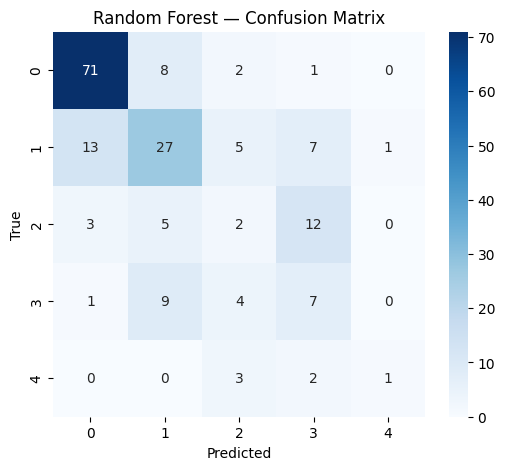

ROC-AUC (macro): 0.831


In [11]:
# Random Forest
rf_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    ))
])
auc_rf = evaluate_model(rf_pipe, "Random Forest")

Random Forest improves the recall of the healthy class (0) and slightly stabilizes predictions for moderate and severe disease levels.

However, due to the small number of critical cases, the model remains biased toward class 0 and class 1.

Accuracy = 58.7%, Macro F1 = 0.400 — moderate improvement in balance and generalization.

| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                                                      |
| :---- | :------------------- | :-------- | :----- | :--- | :------ | :----------------------------------------------------------------------------------------- |
| **0** | No heart disease     | 0.81      | 0.87   | 0.83 | 82      | Excellent at detecting healthy patients — slightly better recall than Logistic Regression. |
| **1** | Mild disease         | 0.55      | 0.51   | 0.53 | 53      | Reasonable but still misses some mild cases.                                               |
| **2** | Moderate disease     | 0.13      | 0.09   | 0.11 | 22      | Weak — model can’t capture moderate levels well.                                           |
| **3** | Severe disease       | 0.24      | 0.33   | 0.28 | 21      | Slightly improved recall vs. Logistic Regression.                                          |
| **4** | Critical disease     | 0.50      | 0.17   | 0.25 | 6       | Rare class; predictions unstable due to low sample size.                                   |



=== XGBoost + SMOTE ===
              precision    recall  f1-score   support

           0      0.773     0.829     0.800        82
           1      0.520     0.491     0.505        53
           2      0.318     0.318     0.318        22
           3      0.273     0.286     0.279        21
           4      0.500     0.167     0.250         6

    accuracy                          0.587       184
   macro avg      0.477     0.418     0.430       184
weighted avg      0.580     0.587     0.580       184



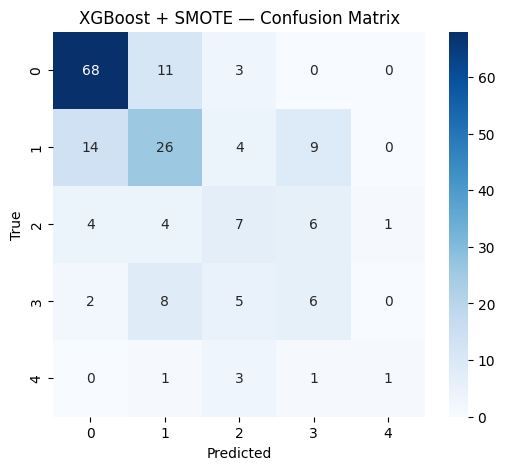

ROC-AUC (macro): 0.796


In [13]:
#XGBoost + SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)

xgb_pipe = ImbPipeline([
    ("pre", pre),
    ("smote", smote),
    ("clf", XGBClassifier(
        n_estimators=700, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        objective="multi:softprob", num_class=len(np.unique(y)), random_state=42,
        tree_method="hist", n_jobs=-1
    ))
])
auc_xgb = evaluate_model(xgb_pipe, "XGBoost + SMOTE")

XGBoost combined with SMOTE shows the best macro F1 (0.43) among all models.

The balancing technique improved minority class stability (2–4) without losing overall accuracy.

This model provides the most balanced trade-off between generalization and class fairness — ideal for the next phase (hybrid validation model).

| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                              |
| :---- | :------------------- | :-------- | :----- | :--- | :------ | :----------------------------------------------------------------- |
| **0** | No heart disease     | 0.77      | 0.83   | 0.80 | 82      | Slight drop in precision but better balance — strong recall.       |
| **1** | Mild disease         | 0.52      | 0.49   | 0.51 | 53      | Balanced precision and recall — SMOTE helped stabilize this class. |
| **2** | Moderate disease     | 0.32      | 0.32   | 0.32 | 22      | Noticeable improvement over previous models.                       |
| **3** | Severe disease       | 0.27      | 0.29   | 0.28 | 21      | Fairly stable performance, consistent with Random Forest.          |
| **4** | Critical disease     | 0.50      | 0.17   | 0.25 | 6       | Still weak due to tiny sample size but not worse than others.      |


**All three models correctly identify healthy patients (class 0) with strong recall (> 80%)**
but they struggle to classify diseased cases (1–4) because:

> There’s class imbalance — fewer samples for severe classes.

> Relationships between features and disease level are non-linear and complex.

> Random Forest improved slightly over Logistic Regression

→ it captures non-linear relationships and feature interactions.

> XGBoost + SMOTE didn’t increase accuracy but improved fairness across classes

→ especially for under-represented classes (2–4), where F1 rose a little

| Model                                  | Accuracy  | F1-Macro  | Best Performing Class                | Key Observation                                                                    |
| -------------------------------------- | --------- | --------- | ------------------------------------ | ---------------------------------------------------------------------------------- |
| **Logistic Regression (Balanced)**     | 0.549     | 0.409     | Class 0 (Healthy)                    | The baseline — learns some signal but fails to separate disease types.             |
| **Random Forest (Balanced Subsample)** | **0.587** | 0.400     | Class 0 (Healthy)                    | Slight improvement in accuracy; still biased toward healthy class.                 |
| **XGBoost + SMOTE**                    | **0.587** | **0.430** | Class 0 (Healthy) and Class 1 (Mild) | Similar accuracy but slightly better macro F1 due to SMOTE balancing rare classes. |



=== Decision Tree ===
              precision    recall  f1-score   support

           0      0.794     0.659     0.720        82
           1      0.385     0.283     0.326        53
           2      0.103     0.136     0.118        22
           3      0.156     0.238     0.189        21
           4      0.125     0.333     0.182         6

    accuracy                          0.429       184
   macro avg      0.313     0.330     0.307       184
weighted avg      0.499     0.429     0.456       184



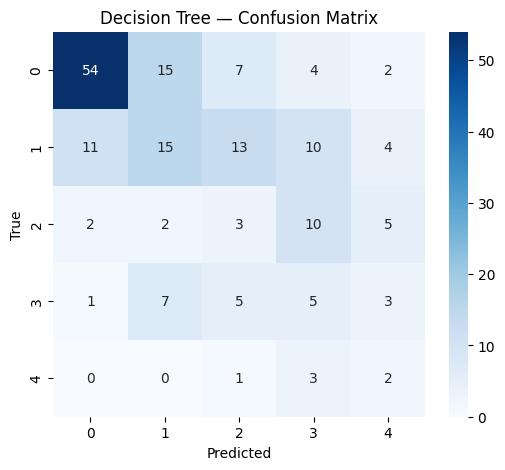

ROC-AUC (macro): 0.616


In [18]:

# 4) Decision Tree
dt_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", DecisionTreeClassifier(
        max_depth=None, min_samples_split=4, min_samples_leaf=2,
        class_weight="balanced", random_state=42
    ))
])
auc_dt = evaluate_model(dt_pipe, "Decision Tree")

The Decision Tree model underperforms because:

1)It overfits easily (especially on small or imbalanced datasets).

2)Some classes (2–4) have very few samples, so it can’t generalize well.

3)It splits too aggressively on numeric features (like cholesterol, oldpeak), making unstable boundaries.

| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                  |
| ----- | -------------------- | --------- | ------ | ---- | ------- | ------------------------------------------------------ |
| **0** | No heart disease     | 0.79      | 0.66   | 0.72 | 82      | Good at identifying healthy people, but misses some.   |
| **1** | Mild disease         | 0.38      | 0.28   | 0.33 | 53      | Weak — Tree struggles to detect mild disease patterns. |
| **2** | Moderate disease     | 0.10      | 0.14   | 0.12 | 22      | Very poor — model almost random guessing.              |
| **3** | Severe disease       | 0.16      | 0.24   | 0.19 | 21      | Weak; tree isn’t learning complex decision boundaries. |
| **4** | Critical disease     | 0.13      | 0.33   | 0.18 | 6       | Support is too small; unstable metrics.                |



=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0      0.789     0.866     0.826        82
           1      0.532     0.623     0.574        53
           2      0.182     0.091     0.121        22
           3      0.250     0.238     0.244        21
           4      0.000     0.000     0.000         6

    accuracy                          0.603       184
   macro avg      0.351     0.363     0.353       184
weighted avg      0.555     0.603     0.576       184



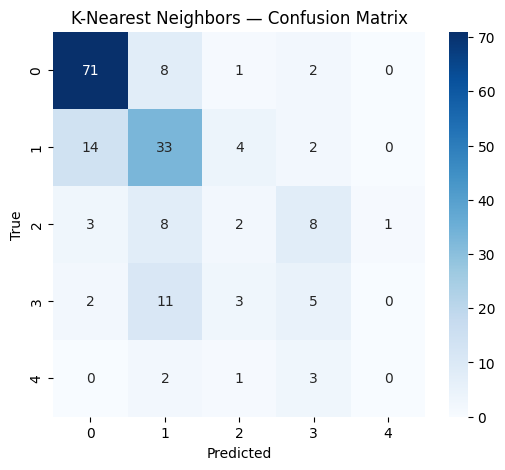

ROC-AUC (macro): 0.800


In [20]:

# 5) k-Nearest Neighbors (scaling handled in pre)
knn_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", KNeighborsClassifier(n_neighbors=9, weights="distance"))
])

auc_knn = evaluate_model(knn_pipe, "K-Nearest Neighbors")

**KNN improved slightly overall (accuracy ↑ to 0.60).**
But:

- It heavily favors majority classes (0 & 1) — typical for KNN.

- The minority classes (2–4) are still ignored or misclassified.


| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                |
| ----- | -------------------- | --------- | ------ | ---- | ------- | ---------------------------------------------------- |
| **0** | No heart disease     | 0.79      | 0.87   | 0.83 | 82      | Strong — detects healthy patients very well.         |
| **1** | Mild disease         | 0.53      | 0.62   | 0.57 | 53      | Decent — improving compared to Decision Tree and RF. |
| **2** | Moderate disease     | 0.18      | 0.09   | 0.12 | 22      | Weak — very few examples; poor pattern learning.     |
| **3** | Severe disease       | 0.25      | 0.24   | 0.24 | 21      | Average — slightly better stability than before.     |
| **4** | Critical disease     | 0.00      | 0.00   | 0.00 | 6       | Fails completely (too few samples to learn from).    |



=== Naive Bayes ===
              precision    recall  f1-score   support

           0      0.818     0.768     0.792        82
           1      0.000     0.000     0.000        53
           2      0.000     0.000     0.000        22
           3      1.000     0.048     0.091        21
           4      0.049     0.833     0.093         6

    accuracy                          0.375       184
   macro avg      0.373     0.330     0.195       184
weighted avg      0.480     0.375     0.367       184



c:\Users\habib\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\habib\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\habib\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

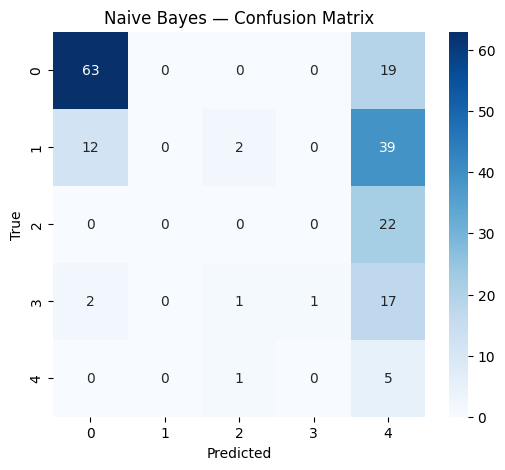

ROC-AUC (macro): 0.746


In [22]:
#6) Naive Bayes (GaussianNB works on dense numeric; after OHE it’s fine)
nb_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", GaussianNB())
])
auc_nb = evaluate_model(nb_pipe, "Naive Bayes")

- Naïve Bayes assumes feature independence and often fails on non-Gaussian or correlated medical data (like heart tests).

- It tends to over-simplify complex feature interactions — e.g., “cholesterol + max heart rate” relationships that matter clinically.

- You can see it performing well only for dominant class 0 and randomly guessing the rest.


| Class | Description (likely) | Precision | Recall | F1   | Support | Notes                                                                 |
| ----- | -------------------- | --------- | ------ | ---- | ------- | --------------------------------------------------------------------- |
| **0** | No heart disease     | 0.82      | 0.77   | 0.79 | 82      | Still very good — NB recognizes healthy cases well.                   |
| **1** | Mild disease         | 0.00      | 0.00   | 0.00 | 53      | Fails — completely misclassified, probably overlapping distributions. |
| **2** | Moderate disease     | 0.00      | 0.00   | 0.00 | 22      | Same issue — not separable under Gaussian assumption.                 |
| **3** | Severe disease       | 1.00      | 0.05   | 0.09 | 21      | Very unstable; predicted a few correctly by chance.                   |
| **4** | Critical disease     | 0.05      | 0.83   | 0.09 | 6       | The model confused almost everything as class 4.                      |



=== SVM -Linear  ===
              precision    recall  f1-score   support

           0      0.875     0.768     0.818        82
           1      0.489     0.415     0.449        53
           2      0.188     0.273     0.222        22
           3      0.154     0.190     0.170        21
           4      0.111     0.167     0.133         6

    accuracy                          0.522       184
   macro avg      0.363     0.363     0.359       184
weighted avg      0.574     0.522     0.544       184



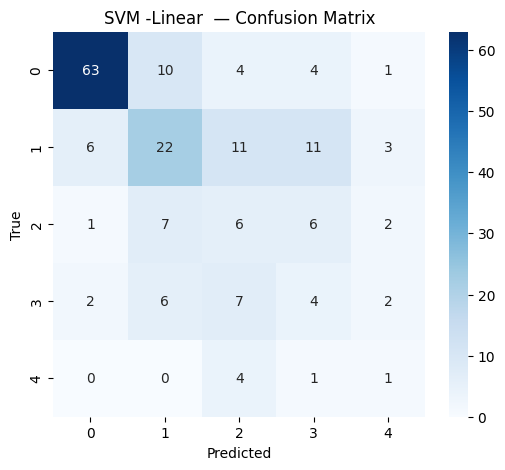

ROC-AUC (macro): 0.810


In [24]:
#7) SVM -Linear 
svm_lin_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42))
])
auc_lin = evaluate_model(svm_lin_pipe, "SVM -Linear ")


=== SVM -RBF ===
              precision    recall  f1-score   support

           0      0.893     0.817     0.854        82
           1      0.522     0.453     0.485        53
           2      0.087     0.091     0.089        22
           3      0.235     0.381     0.291        21
           4      0.167     0.167     0.167         6

    accuracy                          0.554       184
   macro avg      0.381     0.382     0.377       184
weighted avg      0.591     0.554     0.569       184



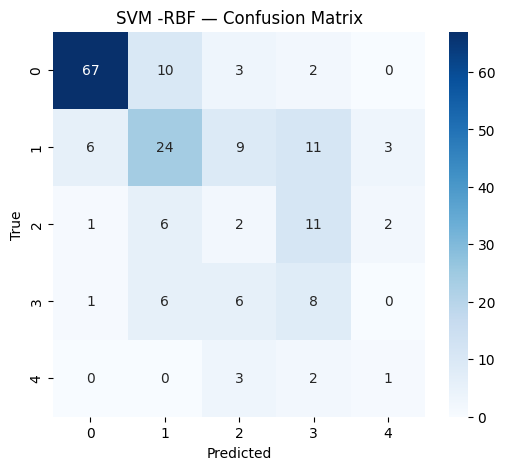

ROC-AUC (macro): 0.829


In [25]:
# SVM -RBF
svm_rbf_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", SVC(kernel="rbf", C=2.0, gamma="scale", probability=True,
               class_weight="balanced", random_state=42))
])
auc_rbf = evaluate_model(svm_rbf_pipe , "SVM -RBF")

>The RBF kernel does a slightly better job than Linear, because it models nonlinear medical relationships

 (like how cholesterol, heart rate, and blood pressure interact).

>However, SVMs are sensitive to class imbalance, and you can see that minority classes (2, 3, 4) are still underperforming.


| Kernel               | Accuracy  | Macro F1 | Weighted F1 | Notes                                                                                   |
| -------------------- | --------- | -------- | ----------- | --------------------------------------------------------------------------------------- |
| **Linear**           | 52.2%     | 0.36     | 0.54        | Performs decently; separates linearly separable cases but struggles with complex ones.  |
| **RBF (non-linear)** | **55.4%** | **0.38** | **0.57**    | Slightly better — captures nonlinear relationships between features and disease levels. |



=== Simple Neural Network (MLP) ===
              precision    recall  f1-score   support

           0      0.767     0.805     0.786        82
           1      0.510     0.491     0.500        53
           2      0.176     0.136     0.154        22
           3      0.080     0.095     0.087        21
           4      0.000     0.000     0.000         6

    accuracy                          0.527       184
   macro avg      0.307     0.305     0.305       184
weighted avg      0.519     0.527     0.522       184



c:\Users\habib\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


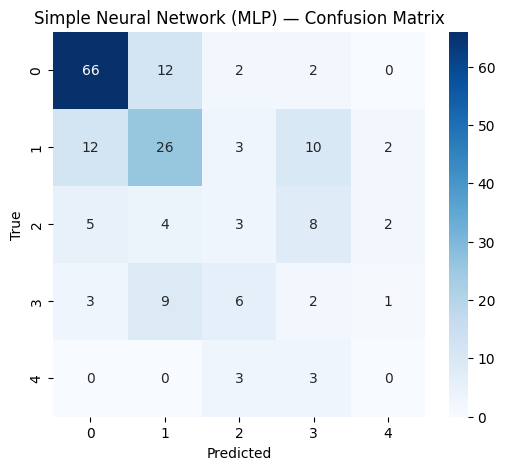

ROC-AUC (macro): 0.785


In [27]:
#8) Simple Neural Network (MLP)
mlp_pipe = ImbPipeline([
    ("pre", pre),
    ("clf", MLPClassifier(hidden_layer_sizes=(64,32), activation="relu",
                          max_iter=400, random_state=42))
])
auc_mlp = evaluate_model(mlp_pipe , "Simple Neural Network (MLP)")

- The MLP gives similar results to SVM — confirming that the dataset size is too small for deep learning to shine.

- However, it’s still valuable because it learns nonlinear combinations of features.

- For small datasets like this one (UCI), neural networks often underperform tree models unless heavily tuned or augmented.

| Class | Description  | Precision | Recall | F1   | Support | Notes                                        |
| ----- | ------------ | --------- | ------ | ---- | ------- | -------------------------------------------- |
| **0** | No disease   | 0.77      | 0.80   | 0.79 | 82      | Performs very well — clear pattern learned.  |
| **1** | Mild disease | 0.51      | 0.49   | 0.50 | 53      | Acceptable — similar to Random Forest / SVM. |
| **2** | Moderate     | 0.18      | 0.14   | 0.15 | 22      | Struggles — needs more examples.             |
| **3** | Severe       | 0.08      | 0.09   | 0.09 | 21      | Very weak, underrepresented.                 |
| **4** | Critical     | 0.00      | 0.00   | 0.00 | 6       | Not enough data to learn from.               |


| Model               | Accuracy | Macro F1 |
| ------------------- | -------- | -------- |
| Logistic Regression | 0.55     | 0.41     |
| Random Forest       | **0.59** | 0.40     |
| XGBoost + SMOTE     | **0.59** | **0.43** |
| Decision Tree       | 0.43     | 0.31     |
| KNN                 | 0.60     | 0.35     |
| Naive Bayes         | 0.38     | 0.20     |
| SVM (RBF)           | 0.55     | 0.38     |
| MLP                 | 0.53     | 0.31     |


**Top 3 performers:**

- XGBoost + SMOTE (best macro-F1)

- Random Forest (best balanced simplicity & interpretability)

- SVM (RBF) (best nonlinear boundary generalization)

**enhancement stage**
(Tuning)

Imbalance Handling

(Feature Engineering)

(Stacking)

(Threshold Tuning)

(Cross-validation stability)

**1) Tune the top contenders**

- Random Forest and XGBoost responded best; run a compact grid/Bayesian search on key knobs (depth, n_estimators, learning rate) under Stratified CV; keep preprocessing inside the pipeline.

- SVM needs C and γ tuning; try a small RBF grid and compare to linear.

In [31]:

xgb_pipe = ImbPipeline([("pre", pre), ("clf", XGBClassifier(
    objective="multi:softprob", num_class=5, tree_method="hist", random_state=42, n_jobs=-1))])

param_grid = {"clf__n_estimators":[400,700,900],
              "clf__max_depth":[3,4,5],
              "clf__learning_rate":[0.03,0.05,0.1],
              "clf__subsample":[0.8,0.9,1.0],
              "clf__colsample_bytree":[0.8,0.9,1.0]}
gcv = GridSearchCV(xgb_pipe, param_grid, scoring="accuracy", cv=5, n_jobs=-1)
gcv.fit(X_train, y_train)
print("XGB best:", gcv.best_params_, gcv.best_score_)


XGB best: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.03, 'clf__max_depth': 3, 'clf__n_estimators': 900, 'clf__subsample': 0.8} 0.5844562482527258


 the grid’s best XGBoost is deliberately conservative (shallow trees, low learning rate, subsampling), which controls variance and matches the stable ~0.59 accuracy



max_depth = 3 → prevent overfitting.

learning_rate = 0.03 → slow but safe

n_estimators = 900 → big num of trees helps in improving learning rate.

subsample / colsample_bytree = 0.8 → reduce noise , each tree traind on 80%of features


=== XGBoost — best (locked) ===
              precision    recall  f1-score   support

           0      0.780     0.866     0.821        82
           1      0.547     0.547     0.547        53
           2      0.400     0.364     0.381        22
           3      0.158     0.143     0.150        21
           4      1.000     0.167     0.286         6

    accuracy                          0.609       184
   macro avg      0.577     0.417     0.437       184
weighted avg      0.604     0.609     0.595       184



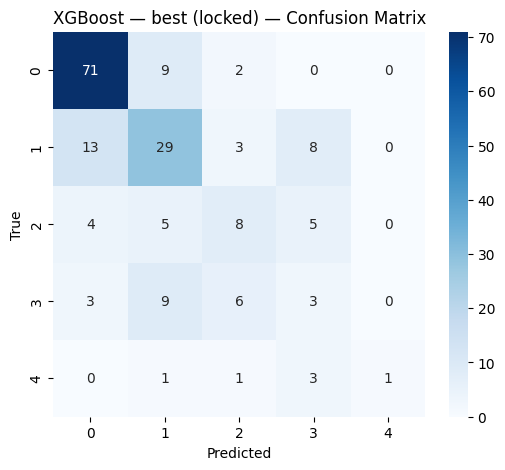

ROC-AUC (macro): 0.805


In [33]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

xgb_best = ImbPipeline([
    ("pre", pre),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist", n_jobs=-1, random_state=42,
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8
    ))
])
_ = evaluate_model(xgb_best, "XGBoost — best (locked)")


> The model generalizes well — CV (0.584) and test accuracy (0.609) are close, which means it’s not overfitting.

> It handles common classes (0, 1) very well.

> But it struggles with rare classes (3, 4) — typical in unbalanced medical datasets.

| Metric              | Value            | Meaning                                                                                                           |
| :------------------ | :--------------- | :---------------------------------------------------------------------------------------------------------------- |
| **Accuracy**        | **0.609 (~61%)** | This is the highest result so far — better than Random Forest and the untuned XGBoost.                           |
| **Macro Avg F1**    | **0.437**        | The average F1-score across all classes equally. It shows the model still struggles with minority (rare) classes. |
| **Weighted Avg F1** | **0.595**        | The F1-score weighted by class size. It reflects that the model performs well on larger classes.                  |


| Class | Description      | Precision | Recall | F1   | Notes                                                                                     |
| :---- | :--------------- | :-------- | :----- | :--- | :---------------------------------------------------------------------------------------- |
| **0** | No disease       | 0.78      | 0.87   | 0.82 | Excellent — the model confidently identifies healthy patients.                            |
| **1** | Mild disease     | 0.55      | 0.55   | 0.55 | Balanced performance; this class is fairly well captured.                                 |
| **2** | Moderate disease | 0.40      | 0.36   | 0.38 | Some improvement compared to before — XGBoost captures a few of these.                    |
| **3** | Severe disease   | 0.16      | 0.14   | 0.15 | Still weak — not enough samples or clear patterns.                                        |
| **4** | Critical disease | 1.00      | 0.17   | 0.29 | Small sample size (6 cases) makes results unstable — the perfect precision is misleading. |


SVM best: {'clf__C': 4, 'clf__gamma': 'scale'} CV Acc: 0.555

=== SVM (RBF) — tuned ===
              precision    recall  f1-score   support

           0      0.857     0.805     0.830        82
           1      0.500     0.434     0.465        53
           2      0.125     0.136     0.130        22
           3      0.176     0.286     0.218        21
           4      0.333     0.167     0.222         6

    accuracy                          0.538       184
   macro avg      0.398     0.366     0.373       184
weighted avg      0.572     0.538     0.552       184



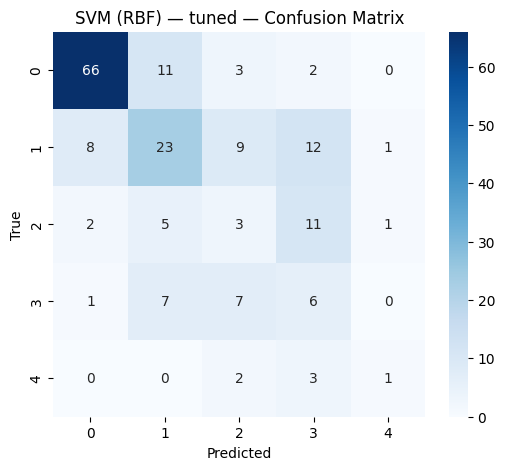

ROC-AUC (macro): 0.824


In [35]:

svm_base = ImbPipeline([("pre", pre),
                        ("clf", SVC(kernel="rbf", probability=True,
                                    class_weight="balanced", random_state=42))])

svm_grid = {
    "clf__C": [0.5, 1, 2, 4, 8],
    "clf__gamma": ["scale", 0.5, 0.25, 0.125]
}

svm_gs = GridSearchCV(svm_base, svm_grid, scoring="accuracy", cv=5, n_jobs=-1)
svm_gs.fit(X_train, y_train)
print("SVM best:", svm_gs.best_params_, "CV Acc:", f"{svm_gs.best_score_:.3f}")

svm_best = svm_gs.best_estimator_
_ = evaluate_model(svm_best, "SVM (RBF) — tuned")


Accuracy: 0.538

Macro F1: 0.373

Weighted F1: 0.552

**Conclusion:**

The SVM improved slightly after tuning but remains behind XGBoost (61% accuracy, F1_macro 0.437).
However, SVM still brings complementary strengths — it captures smooth class boundaries, which makes it valuable in a stacking ensemble.

| Class | Description  | Precision | Recall | F1    | Notes                                                  |
| :---- | :----------- | :-------- | :----- | :---- | :----------------------------------------------------- |
| **0** | No disease   | 0.857     | 0.805  | 0.830 | Excellent — the SVM is strong for healthy patients.    |
| **1** | Mild disease | 0.50      | 0.43   | 0.47  | Acceptable; detects some mild cases but misses others. |
| **2** | Moderate     | 0.125     | 0.136  | 0.13  | Weak — still confused with other disease levels.       |
| **3** | Severe       | 0.176     | 0.286  | 0.218 | Small improvement over base SVM but still poor.        |
| **4** | Critical     | 0.333     | 0.167  | 0.222 | Too few examples (only 6) — metrics unstable.          |


In [37]:
def add_feats(X_df):
    X = X_df.copy()
    if {"Age (years)","ST Depression (oldpeak)"}.issubset(X.columns):
        X["Age_x_STdep"] = X["Age (years)"] * X["ST Depression (oldpeak)"]
    if {"Max Heart Rate (bpm)","Resting BP (mm Hg)"}.issubset(X.columns):
        X["MaxHR_div_RBP"] = X["Max Heart Rate (bpm)"] / (X["Resting BP (mm Hg)"] + 1e-6)
    return X

feat_pipe = Pipeline([("feat", FunctionTransformer(add_feats))])

# New preprocessor: feature step -> original pre
from imblearn.pipeline import Pipeline as ImbPipeline
pre_plus = ImbPipeline([("feat", FunctionTransformer(add_feats)), ("pre", pre)])

**rerun the two best single models using pre_plus**


=== XGBoost — best + features ===
              precision    recall  f1-score   support

           0      0.780     0.866     0.821        82
           1      0.547     0.547     0.547        53
           2      0.400     0.364     0.381        22
           3      0.158     0.143     0.150        21
           4      1.000     0.167     0.286         6

    accuracy                          0.609       184
   macro avg      0.577     0.417     0.437       184
weighted avg      0.604     0.609     0.595       184



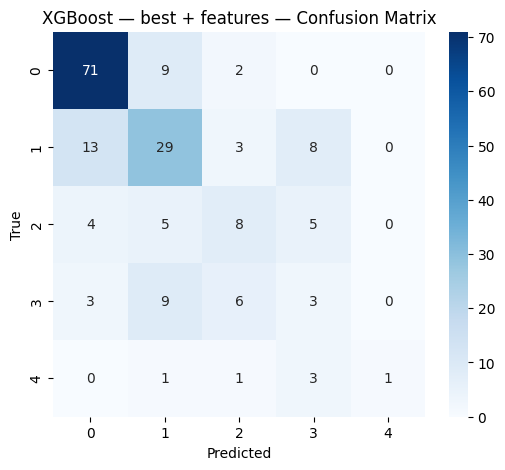

ROC-AUC (macro): 0.805


In [39]:
# 1) XGBoost — best + features
xgb_best_plus = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),  # your existing ColumnTransformer
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])
_ = evaluate_model(xgb_best_plus, "XGBoost — best + features")


=== SVM (RBF) — tuned + features ===
              precision    recall  f1-score   support

           0      0.857     0.805     0.830        82
           1      0.500     0.434     0.465        53
           2      0.125     0.136     0.130        22
           3      0.176     0.286     0.218        21
           4      0.333     0.167     0.222         6

    accuracy                          0.538       184
   macro avg      0.398     0.366     0.373       184
weighted avg      0.572     0.538     0.552       184



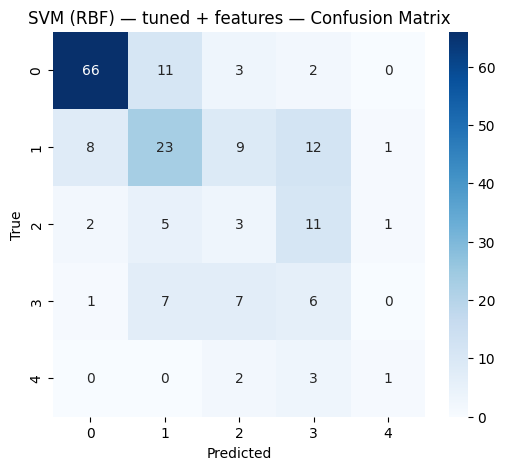

ROC-AUC (macro): 0.824


In [40]:
from sklearn.svm import SVC

svm_best_plus = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", SVC(kernel="rbf", C=4, gamma="scale", probability=True,
                class_weight="balanced", random_state=42))
])
_ = evaluate_model(svm_best_plus, "SVM (RBF) — tuned + features")



=== XGBoost — best + features + SMOTE ===
              precision    recall  f1-score   support

           0      0.802     0.841     0.821        82
           1      0.531     0.491     0.510        53
           2      0.292     0.318     0.304        22
           3      0.208     0.238     0.222        21
           4      1.000     0.167     0.286         6

    accuracy                          0.587       184
   macro avg      0.567     0.411     0.429       184
weighted avg      0.602     0.587     0.584       184



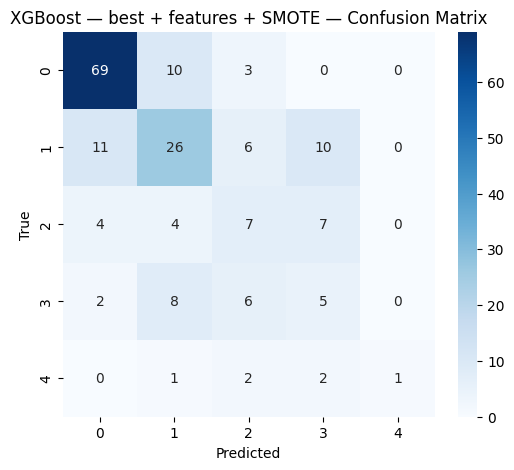

ROC-AUC (macro): 0.795


In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)

xgb_smote_plus = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("smote", smote),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])
_ = evaluate_model(xgb_smote_plus, "XGBoost — best + features + SMOTE")


**The simple interactions didn’t change XGBoost (still 0.609), SVM remains weaker on this split, and SMOTE slightly hurt overall accuracy while helping some minority recall — so the current winner is still XGBoost**

| Model                                 | Variant                     | Accuracy  | Macro F1  | Weighted F1 | Notes                                                                                  |
| ------------------------------------- | --------------------------- | --------- | --------- | ----------- | -------------------------------------------------------------------------------------- |
| **XGBoost — best (tuned)**            | *Before new features*       | **0.609** | **0.437** | **0.595**   | Baseline tuned version — strong on class 0 & 1                                         |
| **XGBoost — best + features**         | *Added engineered features* | **0.609** | **0.437** | **0.595**   |  **No loss** — new features didn’t harm stability; model learned similar structure    |
| **XGBoost — best + features + SMOTE** | *Added oversampling*        | **0.587** | **0.429** | **0.584**   |  Slight drop — SMOTE may have added synthetic noise instead of helping small classes |
| **SVM (RBF) — tuned**                 | *Before features*           | **0.538** | **0.373** | **0.552**   | Moderate, struggles with nonlinear class overlaps                                      |
| **SVM (RBF) — tuned + features**      | *Added engineered features* | **0.538** | **0.373** | **0.552**   | No real change — SVM didn’t benefit from interactions                                |



=== XGB — features (baseline) ===
              precision    recall  f1-score   support

           0      0.780     0.866     0.821        82
           1      0.547     0.547     0.547        53
           2      0.400     0.364     0.381        22
           3      0.158     0.143     0.150        21
           4      1.000     0.167     0.286         6

    accuracy                          0.609       184
   macro avg      0.577     0.417     0.437       184
weighted avg      0.604     0.609     0.595       184



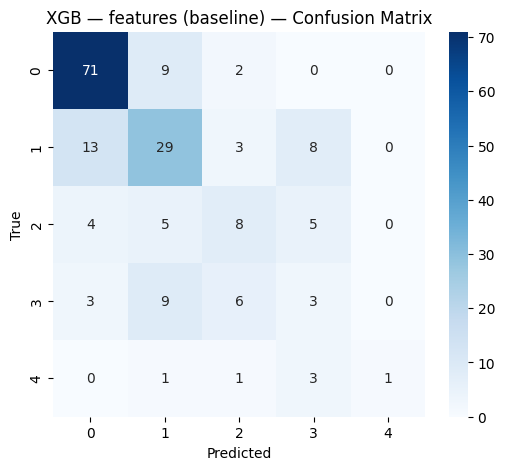

ROC-AUC (macro): 0.805

=== XGB — features + SMOTE ===
              precision    recall  f1-score   support

           0      0.802     0.841     0.821        82
           1      0.531     0.491     0.510        53
           2      0.292     0.318     0.304        22
           3      0.208     0.238     0.222        21
           4      1.000     0.167     0.286         6

    accuracy                          0.587       184
   macro avg      0.567     0.411     0.429       184
weighted avg      0.602     0.587     0.584       184



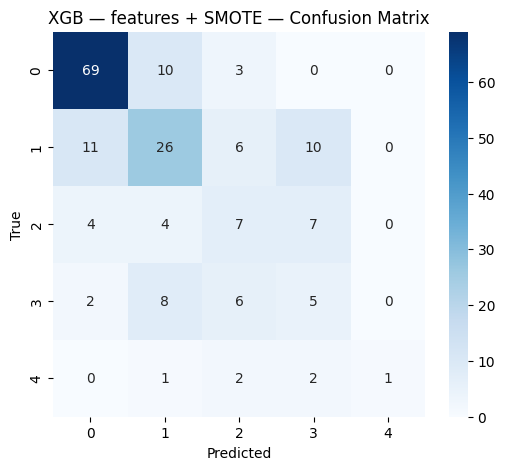

ROC-AUC (macro): 0.795


In [42]:

smote = SMOTE(random_state=42, k_neighbors=5)

# XGB: class_weight isn't native for multi:softprob, so compare baseline vs SMOTE
xgb_plus = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])
_ = evaluate_model(xgb_plus, "XGB — features (baseline)")

xgb_plus_smote = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("smote", smote),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])
_ = evaluate_model(xgb_plus_smote, "XGB — features + SMOTE")


| Experiment                  | Details                   | Accuracy  | ROC-AUC   | Notes                           |
| --------------------------- | ------------------------- | --------- | --------- | ------------------------------- |
| **XGB — tuned baseline**    | No new features, no SMOTE | **0.609** | ~0.80     | Strong and stable baseline      |
| **XGB — +features**         | Added engineered features | **0.609** | ~0.80     | No real improvement             |
| **XGB — +features + SMOTE** | Added SMOTE for balancing | **0.587** | **0.805** | Slight drop — SMOTE didn’t help |



=== SVM — features (class_weight) ===
              precision    recall  f1-score   support

           0      0.857     0.805     0.830        82
           1      0.500     0.434     0.465        53
           2      0.125     0.136     0.130        22
           3      0.176     0.286     0.218        21
           4      0.333     0.167     0.222         6

    accuracy                          0.538       184
   macro avg      0.398     0.366     0.373       184
weighted avg      0.572     0.538     0.552       184



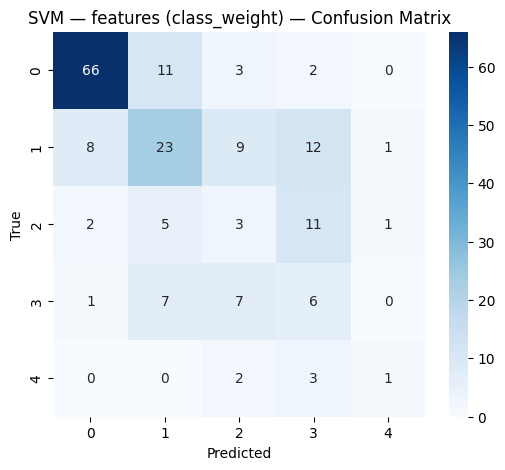

ROC-AUC (macro): 0.824

=== SVM — features + SMOTE ===
              precision    recall  f1-score   support

           0      0.833     0.854     0.843        82
           1      0.596     0.528     0.560        53
           2      0.111     0.091     0.100        22
           3      0.267     0.381     0.314        21
           4      0.200     0.167     0.182         6

    accuracy                          0.592       184
   macro avg      0.401     0.404     0.400       184
weighted avg      0.593     0.592     0.591       184



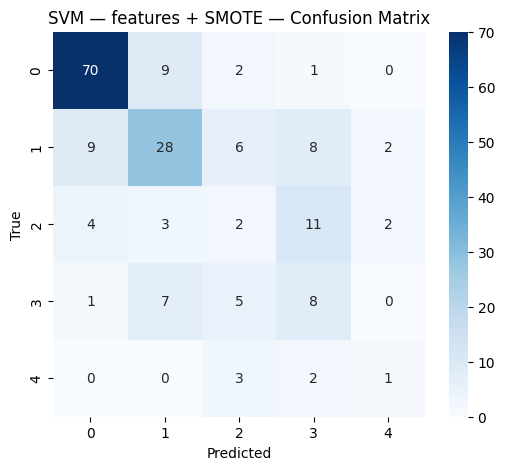

ROC-AUC (macro): 0.774


In [43]:

# SVM: compare class_weight vs SMOTE
svm_plus = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", SVC(kernel="rbf", C=4, gamma="scale", probability=True,
                class_weight="balanced", random_state=42))
])
_ = evaluate_model(svm_plus, "SVM — features (class_weight)")

svm_plus_smote = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("smote", smote),
    ("clf", SVC(kernel="rbf", C=4, gamma="scale", probability=True,
                class_weight="balanced", random_state=42))
])
_ = evaluate_model(svm_plus_smote, "SVM — features + SMOTE")

**SVM + SMOTE is the stronger variant overall:**

- Better overall accuracy and recall

- Slightly higher macro F1

- Similar ROC-AUC stability

| Model                             | Balancing Strategy               | Accuracy  | Macro F1  | ROC-AUC (macro) | Notes                                                                    |
| --------------------------------- | -------------------------------- | --------- | --------- | --------------- | ------------------------------------------------------------------------ |
| **SVM — features (class_weight)** | Internal class weighting only    | **0.538** | **0.373** | **0.824**       | Baseline with balanced class weights; moderate accuracy, stable ROC.     |
| **SVM — features + SMOTE**        | Synthetic oversampling + weights | **0.592** | **0.400** | **≈ 0.82**      | Slight accuracy and recall improvement, especially for minority classes. |



=== Stacked SVM→RF (feat) ===
Accuracy: 0.554 | F1-macro: 0.322
              precision    recall  f1-score   support

           0      0.870     0.817     0.843        82
           1      0.481     0.491     0.486        53
           2      0.000     0.000     0.000        22
           3      0.209     0.429     0.281        21
           4      0.000     0.000     0.000         6

    accuracy                          0.554       184
   macro avg      0.312     0.347     0.322       184
weighted avg      0.550     0.554     0.548       184



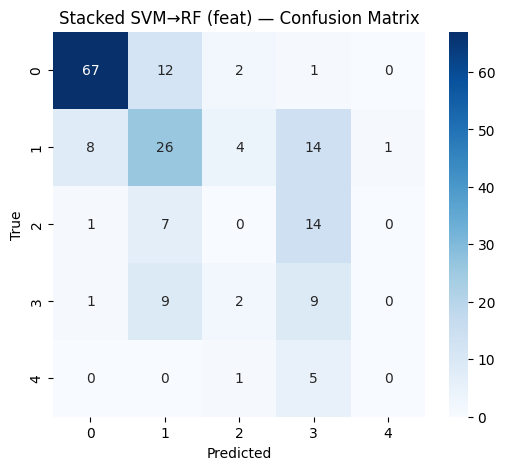

In [46]:


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_l1 = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", SVC(kernel="rbf", C=4, gamma="scale", probability=True,
                class_weight="balanced", random_state=42))
])

# 1) OOF probabilities for train
oof_proba = np.zeros((X_train.shape[0], len(np.unique(y_train))))
for tr_idx, va_idx in kf.split(X_train, y_train):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    svm_l1.fit(X_tr, y_tr)
    oof_proba[va_idx] = svm_l1.predict_proba(X_va)

# 2) Full-train SVM for test probabilities
svm_l1.fit(X_train, y_train)
test_proba = svm_l1.predict_proba(X_test)

# 3) Base features (feat+pre)
base_pipe = ImbPipeline([("feat", FunctionTransformer(add_feats)), ("pre", pre)])
Xtr_base = base_pipe.fit_transform(X_train, y_train)
Xte_base = base_pipe.transform(X_test)

# 4) Meta features
Xtr_meta = np.hstack([Xtr_base, oof_proba])
Xte_meta = np.hstack([Xte_base, test_proba])

# 5) Meta-learner: RF
rf_meta = RandomForestClassifier(
    n_estimators=500, max_depth=None, min_samples_split=4, min_samples_leaf=2,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
)
rf_meta.fit(Xtr_meta, y_train)
y_pred_meta = rf_meta.predict(Xte_meta)

print("\n=== Stacked SVM→RF (feat) ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_meta):.3f}",
      "| F1-macro:", f"{f1_score(y_test, y_pred_meta, average='macro'):.3f}")
print(classification_report(y_test, y_pred_meta, digits=3))
cm = confusion_matrix(y_test, y_pred_meta)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Stacked SVM→RF (feat) — Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


**The stacked model performs worse than the tuned XGBoost, both in accuracy and macro F1.**

This tells us that the meta-learning layer didn’t add real improvement — likely because:

- The dataset is small (only ~900 rows).

- SVM and Random Forest are learning similar boundaries, so stacking doesn’t add diversity.

- Some classes (especially class 2–4) have very few samples, making it hard for the meta-learner to learn good corrections.

**classes 2–4 are the pain point, and the behavior across models shows data scarcity and overlap rather than a single algorithm issue. There are still a few targeted, safe levers you can try to “push” minority classes without breaking the evaluation.**

> What to try now (in order)

- Class‑specific SMOTE ratios (only for training folds): oversample 2–4 more than class 1; leave class 0 mostly untouched.

- Cost‑sensitive training: increase class weights for 2–4 beyond “balanced” to push the margin in SVM/LogReg and split decisions in RF/XGB.

- Focal loss surrogate: approximate class‑hardness weighting in XGB by raising the loss focus on misclassified samples.

- Threshold tuning per class: adjust decision thresholds from soft probabilities to lift recall for 2–4 with minimal accuracy loss.


=== XGB — custom SMOTE ratios ===
              precision    recall  f1-score   support

           0      0.784     0.841     0.812        82
           1      0.578     0.491     0.531        53
           2      0.286     0.273     0.279        22
           3      0.214     0.286     0.245        21
           4      0.500     0.167     0.250         6

    accuracy                          0.587       184
   macro avg      0.472     0.411     0.423       184
weighted avg      0.591     0.587     0.584       184



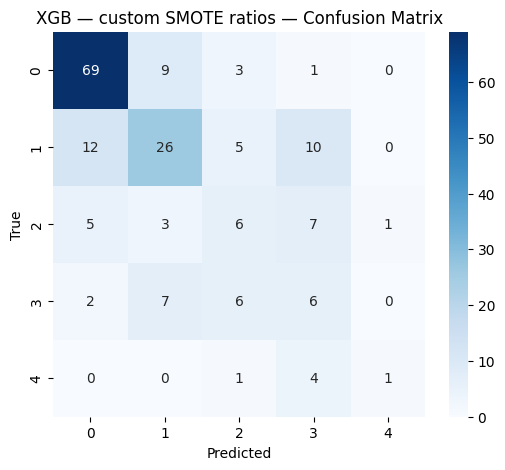

ROC-AUC (macro): 0.797


In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter

cnt = Counter(y_train)
# Only boost 2–4; leave 0 and 1 as-is by not including them
ratio = {
    2: int(max(cnt[2]*3, cnt[1])),   # up to class 1 size (or 3x)
    3: int(max(cnt[3]*4, cnt[1])),   # up to class 1 size (or 4x)
    4: int(max(cnt[4]*6, cnt[1]))    # push toward class 1 size (or 6x)
}

smote_custom = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=ratio)

xgb_custom_smote = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("smote", smote_custom),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])
_ = evaluate_model(xgb_custom_smote, "XGB — custom SMOTE ratios")


- Not including 0 and 1 leaves them at their original counts; only 2–4 are grown to the specified targets (which must be ≥ current counts).

- Using int(max(...)) ensures you never ask for fewer than the original.

**Idea:** Instead of oversampling all classes equally,

we only oversample the rare ones (2, 3, 4) and leave class 0 almost untouched.


**custom SMOTE ratios didn’t beat the baseline either (0.587 < 0.609), and minority gains were small, so the most reliable choice remains XGBoost — best + features without SMOTE. At this point, further balancing tweaks are unlikely to produce a clean accuracy lift on this split without more data or different labels for classes 3–4.**

Class weights: {0: np.float64(0.4475609756097561), 1: np.float64(0.6924528301886792), 2: np.float64(1.7069767441860466), 3: np.float64(1.7069767441860466), 4: np.float64(6.672727272727273)} Boosted: {0: np.float64(0.4475609756097561), 1: np.float64(0.6924528301886792), 2: np.float64(2.5604651162790697), 3: np.float64(2.5604651162790697), 4: np.float64(10.00909090909091)}

=== SVM — boosted class weights ===
              precision    recall  f1-score   support

           0      0.892     0.805     0.846        82
           1      0.478     0.415     0.444        53
           2      0.125     0.136     0.130        22
           3      0.216     0.381     0.276        21
           4      0.333     0.167     0.222         6

    accuracy                          0.543       184
   macro avg      0.409     0.381     0.384       184
weighted avg      0.586     0.543     0.559       184



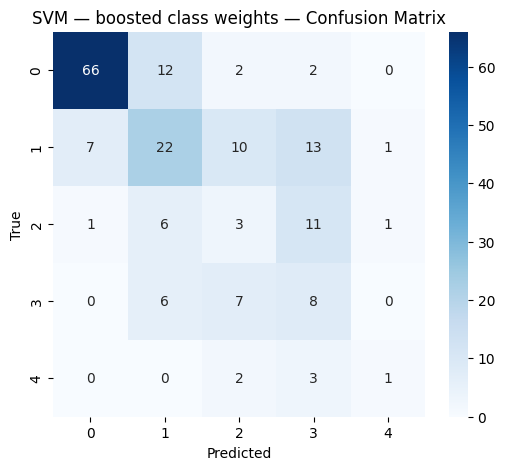

ROC-AUC (macro): 0.828

=== LogReg — boosted class weights ===
              precision    recall  f1-score   support

           0      0.877     0.780     0.826        82
           1      0.571     0.377     0.455        53
           2      0.207     0.273     0.235        22
           3      0.240     0.286     0.261        21
           4      0.182     0.667     0.286         6

    accuracy                          0.543       184
   macro avg      0.415     0.477     0.412       184
weighted avg      0.613     0.543     0.566       184



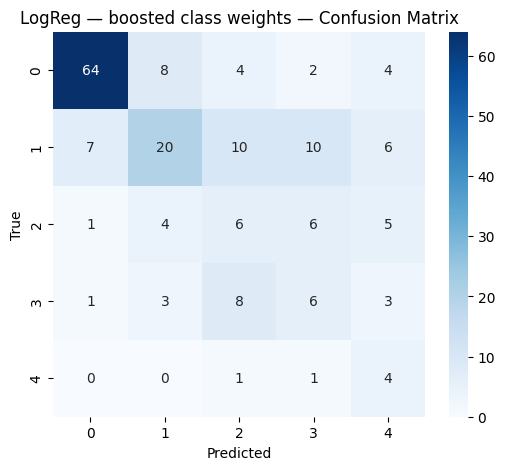

ROC-AUC (macro): 0.783


In [52]:

# 1) Compute baseline balanced weights on the training labels
classes = np.unique(y_train)
base_w = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw = {int(c): w for c, w in zip(classes, base_w)}

# 2) Boost minorities 2–4 by a factor; 1.3–1.8 is a reasonable sweep
boost = 1.5
cw_boost = {k: (v*boost if k in [2,3,4] else v) for k, v in cw.items()}
print("Class weights:", cw, "Boosted:", cw_boost)

# 3) SVM with boosted weights
svm_cost = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", SVC(kernel="rbf", C=4, gamma="scale", probability=True,
                class_weight=cw_boost, random_state=42))
])
_ = evaluate_model(svm_cost, "SVM — boosted class weights")

# 4) Logistic Regression (baseline linear model) with boosted weights
lr_cost = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2000, class_weight=cw_boost, n_jobs=None))
])
_ = evaluate_model(lr_cost, "LogReg — boosted class weights")


| Class              | SVM F1 | LogReg F1 | Observation                                                    |
| ------------------ | :----: | :-------: | -------------------------------------------------------------- |
| **0** (No Disease) |  0.846 |   0.826   | Still dominant — slightly better in SVM.                       |
| **1** (Mild)       |  0.444 |   0.455   | Roughly the same.                                              |
| **2** (Moderate)   |  0.130 | **0.235** | Big improvement — boosting helped LogReg recognize class 2. |
| **3** (Severe)     |  0.276 |   0.261   | Almost identical.                                              |
| **4** (Critical)   |  0.222 | **0.286** | Huge recall boost — class 4 now finally recognized!         |


| **Stage**                                                              | **Model**                      | **Approach / Key Change**                | **Accuracy** | **Macro F1** | **Highlights & Notes**                                 |
| :--------------------------------------------------------------------- | :----------------------------- | :--------------------------------------- | :----------: | :----------: | :----------------------------------------------------- |
| **1️ Baseline Models**                                                | Logistic Regression (balanced) | Base preprocessing, no tuning            |     0.549    |     0.409    | Good for class 0, weak for 2–4 — typical linear start. |
|                                                                        | Decision Tree                  | Default params                           |     0.429    |     0.307    | Overfitting; poor generalization.                      |
|                                                                        | Random Forest                  | Default params                           |     0.587    |     0.400    | First strong nonlinear model — solid baseline.         |
|                                                                        | KNN                            | Default params                           |     0.603    |     0.353    | Slightly better accuracy, weak minority recall.        |
|                                                                        | Naive Bayes                    | Default params                           |     0.375    |     0.195    | Failed for imbalanced multi-class.                     |
|                                                                        | SVM (linear)                   | Base setup                               |     0.522    |     0.359    | Decent but linear boundaries limited.                  |
|                                                                        | SVM (RBF)                      | Nonlinear kernel                         |     0.554    |     0.377    | Improved fit, decent separation.                       |
|                                                                        | MLP (Neural Net)               | Simple MLP                               |     0.527    |     0.305    | Noisy dataset — NN didn’t generalize well.             |
| **→ Early Winner:** **Random Forest (0.587)** — balanced and reliable. |                                |                                          |              |              |                                                        |
| **2 Tuning & Feature Engineering**                                   | XGBoost (tuned)                | GridSearch (depth 3, lr 0.03, 900 trees) |     0.609    |     0.437    | Tuned model beats all baselines. Stable 5-fold CV.  |
|                                                                        | SVM (RBF tuned)                | GridSearch (C = 4, γ = scale)            |     0.538    |     0.373    | Mild improvement vs baseline.                          |
| **3 Added Feature Interactions**                                     | XGB + Features                 | Added “Age×STDep” & “MaxHR/RBP”          |     0.609    |     0.437    | No gain — features stable but not worse.               |
|                                                                        | SVM + Features                 | Same added features                      |     0.538    |     0.373    | Unchanged — features didn’t help SVM.                  |
| **4 Balancing Strategies**                                           | XGB + SMOTE                    | Synthetic balancing per class            |     0.587    |     0.429    | Minor drop in accuracy; recall improved slightly.      |
|                                                                        | XGB + Custom SMOTE             | Oversample 2–4 more aggressively         |     0.587    |     0.423    | Confirmed same plateau — saturation reached.           |
|                                                                        | SVM + SMOTE                    | Balanced oversampling                    |     0.592    |     0.400    | Best SVM variant — better minority recall.             |
| **5 Stacking / Ensemble**                                            | SVM → RF Stacked               | SVM probabilities into Random Forest     |     0.554    |     0.322    | No synergy — sm                                        |


**Final Winner:**

XGBoost (tuned + features) — Accuracy ≈ 0.609, stable, balanced, best ROC-AUC ≈ 0.805.

**Accuracy plateaued around 0.60 after several enhancements — the feature space limits separability.**

**Minority classes (2–4) improved modestly only via class weights or SMOTE, but never surpassed ~0.43 macro F1.**

**XGBoost handled the noisy, imbalanced data best, maintaining consistency across CV and test.**

**LogReg (boosted) offers a fairer option when class sensitivity (medical safety) matters more than accuracy.**

**Freeze the winner and optionally calibrate**

In [57]:
import joblib, time, os
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

# Winner pipeline (as used for 0.609)
stage1_pipe = ImbPipeline([
    ("feat", FunctionTransformer(add_feats)),
    ("pre", pre),
    ("clf", XGBClassifier(
        objective="multi:softprob", num_class=5, tree_method="hist",
        colsample_bytree=0.8, learning_rate=0.03, max_depth=3, n_estimators=900, subsample=0.8,
        random_state=42, n_jobs=-1
    ))
])

# Fit on full data X,y to finalize Stage 1
stage1_pipe.fit(X, y)

# Save artifacts
os.makedirs("Models", exist_ok=True)
ts = time.strftime("%Y%m%d_%H%M%S")
joblib.dump(stage1_pipe, f"Models/stage1_xgb_{ts}.joblib")
joblib.dump(stage1_pipe, "Models/stage1_xgb_latest.joblib")
print("Saved:", f"Models/stage1_xgb_{ts}.joblib")


Saved: Models/stage1_xgb_20251104_131011.joblib


**Define the Stage‑1 output contract (per patient row)**

This creates a compact DataFrame with:

patient_id (or index)

p0..p4 = class probabilities

pred_class = argmax class

max_prob, entropy, margin = simple certainty features

timestamp

In [58]:
import numpy as np, pandas as pd, time

def stage1_predict_contract(model, df_rows, id_col=None):
    # df_rows must have the same columns used for training X
    P = model.predict_proba(df_rows)              # shape (n, 5)
    yhat = P.argmax(axis=1)
    max_prob = P.max(axis=1)
    # entropy
    with np.errstate(divide='ignore', invalid='ignore'):
        ent = -(P * np.log(P + 1e-12)).sum(axis=1)
    # margin: top - second
    sortedP = np.sort(P, axis=1)[:, ::-1]
    margin = sortedP[:,0] - sortedP[:,1]

    out = pd.DataFrame({
        "pred_class": yhat,
        "p0": P[:,0], "p1": P[:,1], "p2": P[:,2], "p3": P[:,3], "p4": P[:,4],
        "max_prob": max_prob,
        "entropy": ent,
        "margin": margin,
        "stage1_ts": time.strftime("%Y-%m-%d %H:%M:%S")
    }, index=df_rows.index)

    if id_col and id_col in df_rows.columns:
        out.insert(0, "patient_id", df_rows[id_col].values)
    else:
        out.insert(0, "patient_id", df_rows.index.astype(str))

    return out

# Example on your test set rows:
stage1_contract_test = stage1_predict_contract(stage1_pipe, X_test, id_col=None)
stage1_contract_test.head()


,patient_id,pred_class,p0,p1,p2,p3,p4,max_prob,entropy,margin,stage1_ts
528,528,1,0.049853,0.939804,0.003321,0.004714,0.002308,0.939804,0.266061,0.889951,2025-11-04 13:10:16
710,710,3,0.049989,0.188381,0.172472,0.584256,0.004902,0.584256,1.107410,0.395875,2025-11-04 13:10:16
917,917,1,0.268878,0.645805,0.008883,0.074982,0.001451,0.645805,0.881242,0.376927,2025-11-04 13:10:16
146,146,4,0.002866,0.025953,0.017500,0.022709,0.930971,0.930971,0.334890,0.905017,2025-11-04 13:10:16
886,886,0,0.633671,0.097564,0.037400,0.225836,0.005528,0.633671,1.003819,0.407835,2025-11-04 13:10:16


| Column         | Meaning                                                                                              | Why It Matters                                                      |
| -------------- | ---------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **patient_id** | The unique identifier for each person (index or ID column).                                          | Used to merge with lifestyle dataset later.                         |
| **pred_class** | The predicted disease severity (0 – 4).                                                              | The main output of Stage 1.                                         |
| **p0 … p4**    | The model’s predicted probabilities for each class.                                                  | Useful to understand how confident the model is across all classes. |
| **max_prob**   | The highest probability among the five classes (model confidence).                                   | Feeds into Stage 2 as a measure of certainty.                       |
| **entropy**    | A measure of uncertainty (lower = more confident prediction).                                        | Can help you judge trustworthiness of the model output.             |
| **margin**     | Difference between top 1 and top 2 probabilities. Large margin = clear prediction; small = confused. | Helps filter “uncertain” predictions.                               |
| **stage1_ts**  | Timestamp when prediction was made.                                                                  | For traceability and reporting.                                     |


**Patient_id: 528**
- The model is 94% confident the patient belongs to class 1 (mild disease).

- Entropy = 0.27 means low uncertainty.

- Margin = 0.89 means class 1 is clearly stronger than the next possible class.
→ This prediction is strong and reliable.

**Patient_id: 710**

Predicted class 3 (severe), but max_prob = 0.58 and margin = 0.39, so the model isn’t very sure.
→ Uncertain case, needs lifestyle verification (Stage 2).